In [1]:
import regex as re
import unicodedata
from glob import glob

def tokenize(text):
    # text = clean(text.lower())
    rx = re.compile(r"\b\p{L}[\p{L}\p{M}\p{N}'’-]*\b", re.UNICODE)
    return rx.findall(text)

In [2]:
from collections import Counter
from operator import itemgetter

counter = Counter()

for f in glob('../data/raw/*.txt'):
    for l in open(f, 'r').readlines():
        counter.update(tokenize(l))

n_most_common_wordtypes = 100
n_features = n_most_common_wordtypes + 2
most_common_wordtypes = list(map(itemgetter(0), counter.most_common(n_most_common_wordtypes))) + ['<BOS>', '<EOS>']
feature_to_ix = dict(zip(most_common_wordtypes, range(len(most_common_wordtypes))))
wordtype_to_ix = dict(zip(counter.keys(), range(len(counter.keys()))))
ix_to_wordtype = dict(zip(wordtype_to_ix.values(), wordtype_to_ix.keys()))
n_wordtypes = len(wordtype_to_ix)

In [3]:
import numpy as np

# extra dimension to count ignored words. to be removed later.
x_wordtype_counts_left = np.zeros((n_wordtypes, n_features + 1)).astype(int)
x_wordtype_counts_right = np.zeros((n_wordtypes, n_features + 1)).astype(int)

for f in glob('../data/raw/*.txt'):
    for l in open(f, 'r').readlines():
        tokens = ['<BOS>'] + tokenize(l) + ['<EOS>']
        for ix in range(1, len(tokens) - 1):
            x_wordtype_counts_left[wordtype_to_ix[tokens[ix]], feature_to_ix.get(tokens[ix-1], -1)] += 1
            x_wordtype_counts_right[wordtype_to_ix[tokens[ix]], feature_to_ix.get(tokens[ix+1], -1)] += 1
            # print(words[ix-1], words[ix], words[ix+1])

# remove ignored words
x_wordtype_counts_left = x_wordtype_counts_left[:, :n_features]  # M (n_wordtypes) x F (n_features)
x_wordtype_counts_right = x_wordtype_counts_right[:, :n_features]  # M (n_wordtypes) x F (n_features)

# x_wordtype_counts_sum_left = x_wordtype_counts_left.sum(axis=1)  # M (n_wordtypes)
# x_wordtype_counts_sum_right = x_wordtype_counts_right.sum(axis=1)  # M (n_wordtypes)

assert x_wordtype_counts_left.shape == x_wordtype_counts_right.shape == (n_wordtypes, n_features)
assert x_wordtype_counts_right.shape == x_wordtype_counts_right.shape == (n_wordtypes, n_features)
# assert x_wordtype_counts_sum_left.shape == (n_wordtypes,)
# assert x_wordtype_counts_sum_right.shape == (n_wordtypes,)

In [4]:
# n_classes = 10

# x_class_priors = np.array([1 / n_classes] * n_classes) # shape: (Z,)
# x_wordtype_class_assignments = np.random.choice(range(len(x_class_priors)), p=x_class_priors, size=n_wordtypes) # shape: (M,)
# x_class_counts = np.bincount(x_wordtype_class_assignments) # shape: (Z,)

# assert x_class_priors.shape == (n_classes,)
# assert x_wordtype_class_assignments.shape == (n_wordtypes,)
# assert x_class_counts.shape == (n_classes,)
# assert x_wordtype_class_assignments.shape == (n_wordtypes,)

# x_class_priors.shape, x_wordtype_class_assignments.shape, x_class_counts.shape, x_wordtype_counts_left.shape, x_wordtype_counts_right.shape

In [5]:
# x_class_wordtype_counts_left = np.zeros((n_classes, n_features)).astype(int)
# x_class_wordtype_counts_right = np.zeros((n_classes, n_features)).astype(int)
# np.add.at(x_class_wordtype_counts_left, x_wordtype_class_assignments, x_wordtype_counts_left)
# np.add.at(x_class_wordtype_counts_right, x_wordtype_class_assignments, x_wordtype_counts_right)
# x_class_wordtype_counts_sum_left = x_class_wordtype_counts_left.sum(axis=1)
# x_class_wordtype_counts_sum_right = x_class_wordtype_counts_right.sum(axis=1)

# assert x_class_wordtype_counts_left.shape == (n_classes, n_features)
# assert x_class_wordtype_counts_right.shape == (n_classes, n_features)
# assert x_class_wordtype_counts_sum_left.shape == (n_classes,)
# assert x_class_wordtype_counts_sum_right.shape == (n_classes,)

In [6]:
from scipy.special import gammaln, logsumexp
from typing import Union, NoReturn, Tuple, List


class GibbsSampler:
    """GibbsSampler."""

    def __init__(self, x_wordtype_counts_left: np.ndarray, x_wordtype_counts_right: np.ndarray, n_classes: int):
        """Init."""
        # validate input params
        assert isinstance(x_wordtype_counts_left, np.ndarray)
        assert isinstance(x_wordtype_counts_right, np.ndarray)
        assert isinstance(n_classes, int)
        assert n_classes > 0

        self._x_wordtype_counts_left = x_wordtype_counts_left
        self._x_wordtype_counts_right = x_wordtype_counts_right
        self._n_classes = n_classes

        # initialise gibbs structures
        self._x_class_priors = np.array([1 / self._n_classes] * self._n_classes) # shape: Z (n_classes,)
        self._n_wordtypes, self._n_features = self._x_wordtype_counts_left.shape
        self._x_wordtype_class_assignments = np.random.choice(range(len(self._x_class_priors)), p=self._x_class_priors, size=self._n_wordtypes) # shape: M (n_wordtypes,)
        self._x_class_counts = np.bincount(self._x_wordtype_class_assignments) # shape: Z (n_classes,)
        self._x_class_wordtype_counts_left = np.zeros((n_classes, n_features)).astype(int)
        self._x_class_wordtype_counts_right = np.zeros((n_classes, n_features)).astype(int)
        np.add.at(self._x_class_wordtype_counts_left, self._x_wordtype_class_assignments, self._x_wordtype_counts_left)
        np.add.at(self._x_class_wordtype_counts_right, self._x_wordtype_class_assignments, self._x_wordtype_counts_right)
        self._x_class_wordtype_counts_sum_left = self._x_class_wordtype_counts_left.sum(axis=1)
        self._x_class_wordtype_counts_sum_right = self._x_class_wordtype_counts_right.sum(axis=1)
        self._x_wordtype_counts_sum_left = self._x_wordtype_counts_left.sum(axis=1)  # M (n_wordtypes)
        self._x_wordtype_counts_sum_right = self._x_wordtype_counts_right.sum(axis=1)  # M (n_wordtypes)

        # validate gibbs structures
        _ = self._validate_initialisation()

    def _validate_initialisation(self) -> Union[None, NoReturn]:
        """Validate initialisation structures."""
        assert self._x_class_priors.shape == (n_classes,)
        assert self._x_wordtype_class_assignments.shape == (n_wordtypes,)
        assert self._x_class_counts.shape == (n_classes,)
        assert self._x_wordtype_class_assignments.shape == (n_wordtypes,)
        assert self._x_class_wordtype_counts_left.shape == (self._n_classes, self._n_features)
        assert self._x_class_wordtype_counts_right.shape == (self._n_classes, self._n_features)
        assert self._x_class_wordtype_counts_sum_left.shape == (self._n_classes,)
        assert self._x_class_wordtype_counts_sum_right.shape == (self._n_classes,)
        assert self._x_wordtype_counts_sum_left.shape == (n_wordtypes,)
        assert self._x_wordtype_counts_sum_right.shape == (n_wordtypes,)
    
    def _compute_log_conditional_probability(self, ix: int, alpha: float, beta_left: float, beta_right: float) -> np.ndarray:
        """Compute Gibbs sampling log conditional."""
        # compute prior
        log_probs: float = np.log(self._x_class_counts + alpha) # drop denominator since its common to all classes.

        # left context features
        log_probs += (
            (
                gammaln(self._x_class_wordtype_counts_left + self._x_wordtype_counts_left[ix] + beta_left)
                - gammaln(self._x_class_wordtype_counts_left + beta_left)
            ).sum(axis=1)
            - (
                gammaln(self._x_class_wordtype_counts_sum_left + self._x_wordtype_counts_sum_left[ix] + self._n_features * beta_left)
                - gammaln(self._x_class_wordtype_counts_sum_left + self._n_features * beta_left)
            )
        )
        
        # right context features
        log_probs += (
            (
                gammaln(self._x_class_wordtype_counts_right + self._x_wordtype_counts_right[ix] + beta_right)
                - gammaln(self._x_class_wordtype_counts_right + beta_right)
            ).sum(axis=1)
            - (
                gammaln(self._x_class_wordtype_counts_sum_right + self._x_wordtype_counts_sum_right[ix] + self._n_features * beta_right)
                - gammaln(self._x_class_wordtype_counts_sum_right + self._n_features * beta_right)
            )
        )
        
        # normalise
        log_probs -= logsumexp(log_probs)
        
        # convert to probs
        probs: float = np.exp(log_probs)

        return probs

    def _compute_log_joint_probability(self, alpha: float, beta_left: float, beta_right: float) -> float:
        """Compute collapsed log joint: log p(z, f | alpha, beta)."""

        # Prior over z: Dirichlet-multinomial on class counts
        log_prob: float = gammaln(self._n_classes * alpha) - gammaln(self._n_wordtypes + self._n_classes * alpha)
        log_prob += (gammaln(self._x_class_counts + alpha) - gammaln(alpha)).sum()

        # Likelihood: product over classes of Dirichlet-multinomial on feature counts
        # left context
        log_prob += (gammaln(self._n_features * beta_left) - gammaln(self._x_class_wordtype_counts_sum_left + self._n_features * beta_left)).sum()
        log_prob += (gammaln(self._x_class_wordtype_counts_left + beta_left) - gammaln(beta_left)).sum()
        # right context
        log_prob += (gammaln(self._n_features * beta_right) - gammaln(self._x_class_wordtype_counts_sum_right + self._n_features * beta_right)).sum()
        log_prob += (gammaln(self._x_class_wordtype_counts_right + beta_right) - gammaln(beta_right)).sum()

        return log_prob
        

    def _remove_class_assignment(self, ix: int) -> int:
        """Remove word type class assignment."""
        assert isinstance(ix, int)
        
        # get word type class assignment
        z: int = self._x_wordtype_class_assignments[ix]
        
        # decrement class count
        self._x_class_counts[z] -= 1
        
        # decrement class word type counts
        self._x_class_wordtype_counts_left[z] -= self._x_wordtype_counts_left[ix]
        self._x_class_wordtype_counts_right[z] -= self._x_wordtype_counts_right[ix]
        
        # decrement from class totals
        self._x_class_wordtype_counts_sum_left[z] -= self._x_wordtype_counts_sum_left[ix]
        self._x_class_wordtype_counts_sum_right[z] -= self._x_wordtype_counts_sum_right[ix]

        return z

    def _add_class_assignment(self, ix: int, z: int) -> None:
        """Add word type class assignment."""
        assert isinstance(ix, int)
        assert isinstance(z, int)
        
        # assign new class
        self._x_wordtype_class_assignments[ix] = z
        
        # increment class count
        self._x_class_counts[z] += 1
        
        # increment class word type counts
        self._x_class_wordtype_counts_left[z] += self._x_wordtype_counts_left[ix]
        self._x_class_wordtype_counts_right[z] += self._x_wordtype_counts_right[ix]
        
        # increment from class totals
        self._x_class_wordtype_counts_sum_left[z] += self._x_wordtype_counts_sum_left[ix]
        self._x_class_wordtype_counts_sum_right[z] += self._x_wordtype_counts_sum_right[ix]
        
    def _run_sweep(self, alpha: float, beta_left: float, beta_right: float) -> None:
        """Run Gibbs sweep."""
        # --- gibbs sweep
        for ix_wordtype in np.random.permutation(self._n_wordtypes):
    
            # --- remove word type assignment
            z_old: int = self._remove_class_assignment(ix=ix_wordtype)
            
            # --- recompute gibbs log conditional
            class_probs: np.ndarray = self._compute_log_conditional_probability(ix=ix_wordtype, alpha=alpha, beta_left=beta_left, beta_right=beta_right)

            # --- sample new assignment
            z_new: int = np.random.choice(self._n_classes, p=class_probs)

            # --- add word type assignment
            _ = self._add_class_assignment(ix=ix_wordtype, z=z_new)

    def compute_posterior_class_probs(self, samples, wordtype_index) -> np.ndarray:
        """Compute empirical posterior P(z_j = c | data) for one word type."""
        x_counts: np.ndarray = np.zeros(self._n_classes, dtype=float)
        for z in samples:
            x_counts[z[wordtype_index]] += 1
        probs: np.ndarray = x_counts / x_counts.sum()
        return probs

    def run(self, n_iterations: int, alpha: float, beta_left: float, beta_right: float, n_burn_in: int, n_thinning: int) -> Tuple[List[float], List[np.ndarray], List[int]]:
        """Run Gibbs sampler."""
        assert isinstance(n_iterations, int)
        assert n_iterations > 0
        assert isinstance(alpha, float)
        assert isinstance(beta_left, float)
        assert isinstance(beta_right, float)

        log_probs_trace, class_counts_trace, samples = [], [], []
        for ix_iteration in range(n_iterations):
            _ = self._run_sweep(alpha=alpha, beta_left=beta_left, beta_right=beta_right)
            log_prob: float = self._compute_log_joint_probability(alpha=alpha, beta_left=beta_left, beta_right=beta_right)

            # trace
            log_probs_trace.append(log_prob)
            class_counts_trace.append(self._x_class_counts.copy())

            # collect thinned samples after burn-in
            if ix_iteration >= n_burn_in and ((ix_iteration - n_burn_in) % n_thinning == 0):
                samples.append(self._x_wordtype_class_assignments.copy())

            # log
            print(f'Iteration: {ix_iteration} log_prob: {log_prob}')

        return log_probs_trace, class_counts_trace, samples


n_classes = 10
n_iterations = 20
n_burn_in = 10
n_thinning = 5
alpha = .1
beta_left, beta_right = .5, .5

sampler = GibbsSampler(x_wordtype_counts_left=x_wordtype_counts_left, x_wordtype_counts_right=x_wordtype_counts_right, n_classes=n_classes)

log_probs_trace, class_counts_trace, samples = sampler.run(
    n_iterations=n_iterations, alpha=alpha, beta_left=beta_left, beta_right=beta_right,
    n_burn_in=n_burn_in, n_thinning=n_thinning,
)

Iteration: 0 log_prob: -3774855.726389806
Iteration: 1 log_prob: -3734119.448015368
Iteration: 2 log_prob: -3721616.447433814
Iteration: 3 log_prob: -3711035.182490377
Iteration: 4 log_prob: -3704001.335275286
Iteration: 5 log_prob: -3696996.0162279233
Iteration: 6 log_prob: -3689844.911809136
Iteration: 7 log_prob: -3685676.5279130233
Iteration: 8 log_prob: -3681852.8095837273
Iteration: 9 log_prob: -3679573.898256923
Iteration: 10 log_prob: -3677418.199096146
Iteration: 11 log_prob: -3676608.171637368
Iteration: 12 log_prob: -3675731.8846086767
Iteration: 13 log_prob: -3674504.640567955
Iteration: 14 log_prob: -3674219.4021168444
Iteration: 15 log_prob: -3674771.1797129028
Iteration: 16 log_prob: -3673975.939476361
Iteration: 17 log_prob: -3674167.7019926356
Iteration: 18 log_prob: -3673066.8356191237
Iteration: 19 log_prob: -3672773.173801137


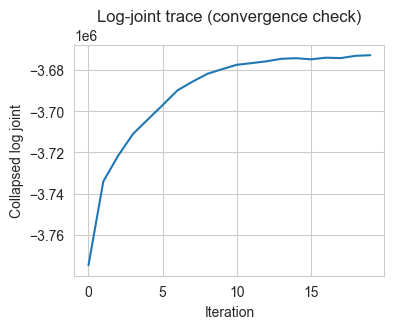

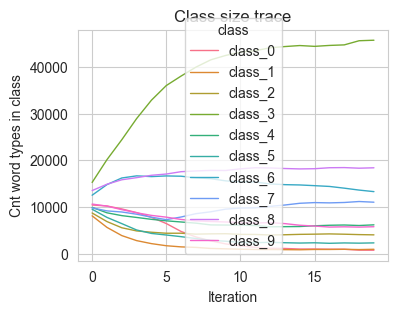

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

_ = sns.set_style('whitegrid')


# Plot log-joint trace
df_plot = pd.DataFrame({
    "iteration": np.arange(len(log_probs_trace)),
    "log_prob": log_probs_trace
})
f, ax = plt.subplots(1, 1, figsize=(4, 3))
_ = sns.lineplot(data=df_plot, x="iteration", y="log_prob", color="C0", ax=ax)
_ = ax.set_xlabel("Iteration")
_ = ax.set_ylabel("Collapsed log joint")
_ = ax.set_title("Log-joint trace (convergence check)")

# Plot class counts (stack or overlay)
x_class_counts_trace = np.stack(class_counts_trace, axis=0)  # shape (T, n_classes)

df_plot = (
    pd.DataFrame(x_class_counts_trace, columns=[f"class_{z}" for z in range(n_classes)])
    .assign(iteration=np.arange(len(x_class_counts_trace)))
    .melt(id_vars="iteration", var_name="class", value_name="count")
)

f, ax = plt.subplots(1, 1, figsize=(4, 3))
_ = sns.lineplot(data=df_plot, x="iteration", y="count", hue="class", palette="husl", linewidth=1, ax=ax)
_ = ax.set_xlabel("Iteration")
_ = ax.set_ylabel("Cnt word types in class")
_ = ax.set_title("Class size trace")

In [21]:
def compute_posterior_class_probs(samples, wordtype_index, n_classes) -> np.ndarray:
    """Compute empirical posterior P(z_j = c | data) for one word type."""
    x_counts: np.ndarray = np.zeros(n_classes, dtype=float)
    for z in samples:
        x_counts[z[wordtype_index]] += 1
    probs: np.ndarray = x_counts / x_counts.sum()
    return probs

# compute_posterior_class_probs(samples, word_idx, n_classes)

In [28]:
word_ix = 5
posterior_probs = compute_posterior_class_probs(samples, word_ix, n_classes)
posterior_probs
# df_plot = pd.DataFrame({
#     "class": np.arange(n_classes),
#     "probability": posterior_probs

# })

# f, ax = plt.subplots(1, 1, figsize=(4, 3))
# _ = sns.barplot(data=df_plot, x="class", y="probability", ax=ax)
# _ = ax.set_title(f"Posterior class probabilities for word '{ix_to_wordtype[word_ix]}'")
# _ = ax.set_xlabel("Class")
# _ = ax.set_ylabel("Prob")

array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])